In [1]:
from etcpy import etc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests

[0, 2, 4, 6, 8]


In [2]:
model = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles.pkl','rb'))

In [3]:
def load_param_mean_std(population):
    # return a datafram with Tm, Topt, dCpt as columns
    params_lst = {idd:[p[idd] for p in population] for idd in population[0].keys()}
    df = pd.DataFrame()
    
    for idd,lst in params_lst.items():
        [prot,param] = idd.split('_')
        if param in ['Tm','Topt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst) - 273.15 # C
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)
        if param in ['dCpt']:
            df.loc[prot,'{0}_mean'.format(param)] = np.mean(lst)/1000 # kJ/mol/K
            df.loc[prot,'{0}_std'.format(param)] = np.std(lst)/1000
    return df

In [4]:
dfpost = load_param_mean_std(model.population)

In [5]:
# update params with posterior params mean
post_params = GEMS.params.copy()
for enz in post_params.index:
    post_params.loc[enz,'Topt'] = dfpost.loc[enz,'Topt_mean'] + 273.15
    post_params.loc[enz,'Tm']   = dfpost.loc[enz,'Tm_mean'] + 273.15
    post_params.loc[enz,'dCpt'] = dfpost.loc[enz,'dCpt_mean']*1000
    
    if ~np.isnan(post_params.loc[enz,'T90']):
        dT = GEMS.params.loc[enz,'T90']-GEMS.params.loc[enz,'Tm']
        post_params.loc[enz,'T90']   = post_params.loc[enz,'Tm'] + dT

In [6]:
dftherm = etc.calculate_thermal_params(post_params)

cs = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
Ts = np.arange(0,64) 
fNTs = list()
sort_enzymes_on_Tm = dftherm.index[np.argsort(post_params['Tm'].values)]
for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt']
    [dHTH, dSTS,dCpu,topt]=dftherm.loc[enz,cols]
    fNT = etc.get_fNT(Ts + 273.15,dHTH,dSTS,dCpu)
    fNTs.append(fNT)

#c = 'inferno'
for c in cs:
    print(c)
    plt.figure(figsize=(2.8,2.4))
    sns.heatmap(fNTs,cmap=c)
    plt.yticks([])
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('{0} enzymes sorted on $T_m$'.format(len(dftherm.index)))
    plt.tight_layout()
    #plt.savefig('../figures/denature_heatmap.png',bbox_inches='tight',dpi=300)
    plt.show()

copper


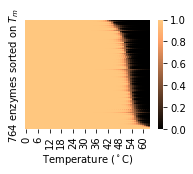

In [8]:
Ts = np.arange(0,64) 
fNTs = list()
sort_enzymes_on_Tm = dftherm.index[np.argsort(post_params['Tm'].values)]
for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt']
    [dHTH, dSTS,dCpu,topt]=dftherm.loc[enz,cols]
    fNT = etc.get_fNT(Ts + 273.15,dHTH,dSTS,dCpu)
    fNTs.append(fNT)

c = 'copper'#'summer_r'#YlGn
#for c in cs:
print(c)
plt.figure(figsize=(2.8,2.4))
sns.heatmap(fNTs,cmap=c)
plt.yticks([])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('{0} enzymes sorted on $T_m$'.format(len(dftherm.index)))
plt.tight_layout()
plt.savefig('../figures/denature_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
c = 'copper'

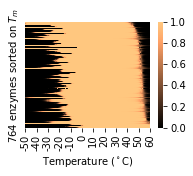

In [9]:
Ts = np.arange(-50,60) 
fNTs = list()
sort_enzymes_on_Tm = dftherm.index[np.argsort(post_params['Tm'].values)]

df3d = pd.DataFrame(index=sort_enzymes_on_Tm,columns=Ts)

for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt']
    [dHTH, dSTS,dCpu,topt]=dftherm.loc[enz,cols]
    fNT = etc.get_fNT(Ts + 273.15,dHTH,dSTS,dCpu)
    fNTs.append(fNT)
df3d.loc[sort_enzymes_on_Tm,Ts] = np.array(fNTs)
df3d = df3d.astype(float)
df3d.to_csv('../SourceData/fig_3d.csv',float_format='%.4f')

plt.figure(figsize=(2.8,2.4))
sns.heatmap(fNTs,cmap=c)
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.xticks(np.arange(0,100+20,10),np.arange(-50,-50+100+20,10))
plt.ylabel('{0} enzymes sorted on $T_m$'.format(len(dftherm.index)))
plt.tight_layout()
plt.savefig('../figures/denature_heatmap_cold.png',bbox_inches='tight',dpi=300)
plt.show()

Ts = np.arange(0,64) 
kcatTs = list()
sort_enzymes_on_Topt = dftherm.index[np.argsort(post_params['Topt'].values)]
for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt','dCpt']
    [dHTH, dSTS,dCpu,Topt,dCpt]=dftherm.loc[enz,cols]
    kcatT = etc.calculate_kcatT(Ts+273.15,dHTH,dSTS,dCpu,1,dCpt,Topt)
    kcatTs.append(kcatT)
plt.figure(figsize=(2.8,2.4))
sns.heatmap(kcatTs,cmap=c)
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.ylabel('%s enzymes sorted on $T_{m}$' % len(dftherm.index))
plt.tight_layout()
plt.savefig('../figures/kcat_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

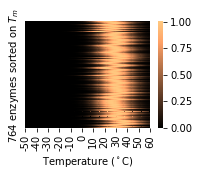

In [11]:
Ts = np.arange(-50,60) 
kcatTs = list()
sort_enzymes_on_Topt = dftherm.index[np.argsort(post_params['Tm'].values)]

df3e = pd.DataFrame(index=sort_enzymes_on_Tm,columns=Ts)

for enz in sort_enzymes_on_Tm:
    cols = ['dHTH', 'dSTS','dCpu','Topt','dCpt']
    [dHTH, dSTS,dCpu,Topt,dCpt]=dftherm.loc[enz,cols]
    kcatT = etc.calculate_kcatT(Ts+273.15,dHTH,dSTS,dCpu,1,dCpt,Topt)
    kcatTs.append(kcatT)

df3e.loc[sort_enzymes_on_Tm,Ts] = np.array(kcatTs)
df3e = df3e.astype(float)
df3e.to_csv('../SourceData/fig_3e.csv',float_format='%.4f')

plt.figure(figsize=(2.8,2.4))
sns.heatmap(kcatTs,cmap=c)
plt.xlabel('Temperature ($^\circ$C)')
plt.xticks(np.arange(0,100+20,10),np.arange(-50,-50+100+20,10))
plt.yticks([])
plt.ylabel('%s enzymes sorted on $T_{m}$' % len(dftherm.index))
plt.tight_layout()
plt.savefig('../figures/kcat_heatmap_cold.png',bbox_inches='tight',dpi=300)
plt.show()

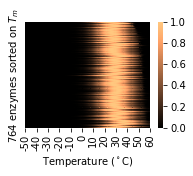

In [15]:
SAs = np.array(fNTs)*np.array(kcatTs)

df3f = pd.DataFrame(index=sort_enzymes_on_Tm,columns=Ts)

df3f.loc[sort_enzymes_on_Tm,Ts] = np.array(SAs)
df3f = df3f.astype(float)
df3f.to_csv('../SourceData/fig_3f.csv',float_format='%.4f')

plt.figure(figsize=(2.8,2.4))
sns.heatmap(SAs,cmap=c)
plt.xlabel('Temperature ($^\circ$C)')
plt.yticks([])
plt.xticks(np.arange(0,100+20,10),np.arange(-50,-50+100+20,10))
plt.ylabel('%s enzymes sorted on $T_{m}$' % len(dftherm.index))
plt.tight_layout()
plt.savefig('../figures/Sa_heatmap.png',bbox_inches='tight',dpi=300)
plt.show()

129

-185.0

In [19]:
dftherm.head()

,dHTH,dSTS,dCpu,Topt,dCpt
O13525,1.483000e+06,4893.450000,16132.124882,304.383942,-6303.243842
P00044,1.297372e+06,4263.848039,12354.234601,308.056808,-6780.270704
P00045,5.950000e+05,1947.510000,6636.120470,311.153254,-6073.135267
P00127,7.310000e+05,2398.690000,7677.937575,301.887468,-6887.987642
P00128,6.510000e+05,2133.290000,6579.105203,297.764072,-6560.470954


In [17]:
post_params.head()

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,304.383942,13,335,324.285927,5.91247,NaN,-6303.243842,2000
P00044,308.056808,13,109,321.519662,3.40000,324.351882,-6780.270704,2000
P00045,311.153254,13,113,331.309673,5.91247,NaN,-6073.135267,2000
P00127,301.887468,13,147,326.611520,5.91247,NaN,-6887.987642,2000
P00128,297.764072,13,127,325.823369,5.91247,NaN,-6560.470954,2000


In [6]:
fNTs = dict()
kcatTs = dict()

In [13]:
np.isnan(GEMS.params.loc['O13525','T90'])

True

In [12]:
GEMS.params.loc['O13525','T90']

nan

In [8]:
GEMS.params.head()

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,310.15,13,335,324.625351,5.91247,NaN,-6300,2000
P00044,314.15,13,109,321.817780,3.40000,324.65,-6300,2000
P00045,317.15,13,113,324.625351,5.91247,NaN,-6300,2000
P00127,317.15,13,147,324.625351,5.91247,NaN,-6300,2000
P00128,309.15,13,127,324.625351,5.91247,NaN,-6300,2000


In [9]:
dfpost.head()

,Tm_mean,Tm_std,Topt_mean,Topt_std,dCpt_mean,dCpt_std
O13525,51.135927,4.564094,31.233942,3.879392,-6.303244,1.802793
P00044,48.369662,5.158030,34.906808,3.241330,-6.780271,3.455483
P00045,58.159673,7.309203,38.003254,4.682154,-6.073135,1.239030
P00127,53.461520,4.411527,28.737468,7.838538,-6.887988,1.357107
P00128,52.673369,5.439958,24.614072,6.719203,-6.560471,1.568349


#### half kcat T

In [17]:
def find_half_kcat_T(kcatT,Ts):
    Tkcat = None
    for i in range(len(Ts)-1):
        i += 1
        if kcatT[-i]<0.5 and kcatT[-i-1]>0.5:
            Tkcat = 0.5*(Ts[-i]+Ts[-i-1])
            break

    if Tkcat is not None: return Tkcat

In [18]:
def save_half_kcat_T():
    outfile = '../results/half_kcat_T_posterior.csv'
    
    Ts = np.arange(0,100,0.1) 
    df = pd.DataFrame()
    sort_enzymes_on_Tm = dftherm.index[np.argsort(post_params['Tm'].values)]
    for enz in sort_enzymes_on_Tm:
        cols = ['dHTH', 'dSTS','dCpu','Topt','dCpt']
        [dHTH, dSTS,dCpu,Topt,dCpt]=dftherm.loc[enz,cols]
        kcatT = etc.calculate_kcatT(Ts+273.15,dHTH,dSTS,dCpu,1,dCpt,Topt)
        df.loc[enz,'half_kcat_T'] = find_half_kcat_T(kcatT,Ts)
        
        fNT = etc.get_fNT(Ts + 273.15,dHTH,dSTS,dCpu)
        df.loc[enz,'Tm'] = dfpost.loc[enz,'Tm_mean']
        
        SAs = np.array(fNT)*np.array(kcatT)
        
        df.loc[enz,'half_SA_T'] = find_half_kcat_T(SAs,Ts)
    
    df.to_csv(outfile)
    print(df.head())

In [38]:
save_half_kcat_T()

/cephyr/NOBACKUP/groups/snic2020-8-46/GitHub/BayesianGEM/code/etcpy/etc.py:95: RuntimeWarning: overflow encountered in exp
  f = 1/(1+np.exp(-dGu/R/T));


        half_kcat_T         Tm  half_SA_T
P32476        36.95  36.794409      35.35
P07251        34.25  37.493722      34.15
P40825        36.55  40.631868      36.55
P15180        35.75  40.871440      35.65
P33330        39.25  41.125420      38.45


In [19]:
df50 = pd.read_csv('../results/half_kcat_T_posterior.csv',index_col=0)

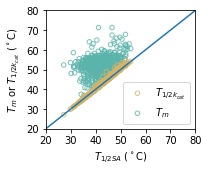

In [20]:
plt.figure(figsize=(3,2.5))
plt.scatter(df50['half_SA_T'],df50['half_kcat_T'],label='$T_{1/2 k_{cat}}$',
            edgecolor='#d8b365',
            facecolor='none',
            s=20,
            alpha=0.8,
            zorder=1
           )
plt.scatter(df50['half_SA_T'],df50['Tm'],label='$T_m$',
            edgecolor='#5ab4ac',
            facecolor='none',
            s=20,
            alpha=0.8,
            zorder=0)

lim = [20,80]
plt.plot(lim,lim,zorder=2)
plt.xlim(lim)
plt.ylim(lim)
plt.xticks(np.arange(20,90,10))
plt.yticks(np.arange(20,90,10))
plt.legend()
plt.xlabel('$T_{1/2 SA}$ ($^\circ$C)')
plt.ylabel('$T_m$ or $T_{1/2 k_{cat}}$ ($^\circ$C)')
plt.tight_layout()
plt.savefig('../figures/T_50SA_vs_Tm_vs_T50kcat.pdf')
plt.show()


In [22]:
df50.to_csv('../SourceData/fig_3c.csv',float_format='%.2f')